In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy import integrate
from matplotlib import cm

## Метод колокації

Маємо інтегральне рівняння вигляду

$$
\dots
$$

Наближений розв'язок будемо шукати у вигляді

 $$
 \tilde{\psi_k}(x)=\sum_{j=1}^{n} c^{(k)}_{j} \gamma^{(k)}_{j}(x), \quad k = 1,2
 $$

де $c_j$ - невідомі константи, які потрібно знайти, а $\gamma_j$ - задані лінійнонезалежні функції (в нашому випадку кусково аналітичні), $j = 1, ..., n$.

Розглянувши його на множині точок $x_i$, таких, що
$$
a \leqslant x_{1}<x_{2}<\ldots<x_{m} \leqslant b
$$

отримаємо СЛАР відносно невідомих $с^{(k)}_j$, $j = 1, ..., n$. 

 $$
 A =
 \begin{pmatrix}
	 \begin{matrix}
	 	G^{(1)}_{11} & \dots  & G^{(1)}_{1n} \\
	 	\vdots 		 & \ddots & \\
	 	G^{(1)}_{n1} & 		  & G^{(1)}_{nn} \\
	 \end{matrix} &
	 \begin{matrix}
	 	G^{(2)}_{11} & \dots  & G^{(2)}_{1n} \\
	 	\vdots 		 & \ddots & \\
	 	G^{(2)}_{n1} & 		  & G^{(2)}_{nn} \\
	 \end{matrix} \\
	 \begin{matrix}
		G^{(3)}_{11} & \dots  & G^{(3)}_{1n} \\
		\vdots 		 & \ddots & \\
		G^{(3)}_{n1} & 		  & G^{(3)}_{nn} \\
	 \end{matrix} &
	 \begin{matrix}
		G^{(4)}_{11} & \dots  & G^{(4)}_{1n} \\
		\vdots 		 & \ddots & \\
		G^{(4)}_{n1} & 		  & G^{(4)}_{nn} \\
	 \end{matrix} \\
 \end{pmatrix}
 c = 
 \begin{pmatrix}
	c^{(1)}_1\\
	\vdots\\
	c^{(1)}_n\\
	c^{(2)}_1\\
	\vdots\\
	c^{(2)}_n\\
 \end{pmatrix}
 g = 
 \begin{pmatrix}
	2\pi g_1(x_1)\\
	\vdots\\
	2\pi g_1(x_n)\\
	2\pi g_2(x_1)\\
	\vdots\\
	2\pi g_2(x_n)\\
 \end{pmatrix}
 $$

In [2]:
a, b = 0, 2*np.pi

r1 = 0.9
r2 = 2
n = 50
eps = 1e-50
h = (b - a) / (n - 1)
xx = [a + (h * i) for i in range(n)]

x1 = lambda t: (r1*np.cos(t), r1*np.sin(t))
x2 = lambda t: (r2*np.cos(t), r2*np.sin(t))
dx1 = lambda t: (-r1*np.sin(t), r1*np.cos(t))
dx2 = lambda t: (-r2*np.sin(t), r2*np.cos(t))
ddx2 = lambda t: (-r2*np.cos(t), -r2*np.sin(t))

In [3]:
# g1 = lambda t: 1
# g2 = lambda t: 0

# u = lambda x, y : 1

In [4]:
# def g1(t):
#     x, y = x1(t)
#     return x

# def g2(t):
#     x, y = x2(t)
#     v = np.array([dx2(t)[1], -dx2(t)[0]]) / LA.norm(dx2(t))
#     grad = np.array([1, 0])
    
#     return np.dot(grad, v)

# u = lambda x, y : x

In [5]:
def g1(t):
    x, y = x1(t)
    return x**2 - y**2

def g2(t):
    x, y = x2(t)
    v = np.array([dx2(t)[1], -dx2(t)[0]]) / LA.norm(dx2(t))
    grad = np.array([2*x, -2*y])
    
    return np.dot(grad, v)

u = lambda x, y : x**2 - y**2

In [6]:
def nu_x2(t):
    return np.array([dx2(t)[1], -dx2(t)[0]]) / LA.norm(dx2(t))

def K11_1(t, tau):
    return -1/2

def K11_2(t, tau):
    if np.abs(t - tau) > eps:
        return 1/2*np.log( 4/np.e * np.sin((t - tau)/2)**2 \
                 / LA.norm(np.subtract(x1(t), x1(tau)))**2)
    else:
        return 1/2*np.log(1/(np.e * LA.norm(dx1(t))**2))

def K12(t, tau):
    return np.log(1/(LA.norm(np.subtract(x1(t), x2(tau)))))

def K21(t, tau):
    return np.dot(np.subtract(x1(tau), x2(t)), nu_x2(t)) \
            / (LA.norm(np.subtract(x2(t), x1(tau)))**2)

def K22(t, tau):
    if np.abs(t - tau) > eps:
        return np.dot(np.subtract(x2(tau), x2(t)), nu_x2(t)) \
                / LA.norm(np.subtract(x2(t), x2(tau)))**2
    else:
        return np.dot(ddx2(t), nu_x2(t)) / ((2*LA.norm(dx2(t)))**2)

In [7]:
def basicFunction(j, x, xx=xx, h=h):
    n = len(xx) - 1
    
    if j >=1 and xx[j-1] <= x <= xx[j]:
        return (x - xx[j-1])/h
    elif j <= n-1 and xx[j] <= x <= xx[j+1]:
        return (xx[j+1] - x)/h
    else:
        return 0

In [8]:
def quadrature_with_ln_special_case(f, M=n):
    '''integral from 0 to 2pi'''

    tt = [i*np.pi/M for i in range(2*M)]

    R = lambda i, t: -1/(2*M) * (1
                                 + 2*sum([(1/m) * np.cos(m * (t - tt[i])) for m in range(1, M)])
                                 + 1/(M) * np.cos(t - tt[i]))
  
    def integral(t):
        return sum([R(j,t)*f(tt[j]) for j in range(2*M)])
  
    return integral

# def R_j( M, t, tj ):
#     sum = 0;
#     for m in range(1, M-1):
#         sum = sum + np.cos(m*(t-tj))/m;     
    
#     return -1/(2*M)*(2*sum + np.cos(M*(t-tj))/M); 

In [9]:
def Collocation(xx):
    n = len(xx)
    
    def collocate(K):
        A = np.zeros([n, n])

        for i in range(n):
            for j in range(n):
                Kxi_li = lambda s: K(xx[i], s) * basicFunction(j, s)

                if (j == 0):
                    (quad, err) = integrate.quad(Kxi_li, xx[j], xx[j + 1])
                elif (j == n - 1):
                    (quad, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j])
                else:
                    (quad, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j + 1])

                A[i][j] = quad

        return A
    
    return collocate

In [10]:
collocate = Collocation(xx)

In [11]:
G1 = np.zeros((n,n)).tolist()
for i in range(n):
    for j in range(n):
        Kxi_li = lambda s: K11_2(xx[i], s) * basicFunction(j, s)

        K_1 = 2 * np.pi * quadrature_with_ln_special_case(lambda s: K11_1(xx[i], s)*basicFunction(j, s))(xx[i])
        
        if (j == 0):
            (K_2, err) = integrate.quad(Kxi_li, xx[j], xx[j + 1])
        elif (j == n - 1):
            (K_2, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j])
        else:
            (K_2, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j + 1])

        G1[i][j] = K_1 + K_2


In [12]:
G2 = collocate(K12)

In [13]:
G3 = collocate(K21) 

In [14]:
G4 = np.zeros((n,n)).tolist()
for i in range(n):
    for j in range(n):
        
        term = lambda j, x: np.pi / (LA.norm(dx2(x)))
        Kxi_li = lambda s: K22(xx[i], s) * basicFunction(j, s)
        
        if (j == 0):
            (quad, err) = integrate.quad(Kxi_li, xx[j], xx[j + 1])
        elif (j == n - 1):
            (quad, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j])
        else:
            (quad, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j + 1])

        G4[i][j] = quad
    
    G4[i][i] += term(i, xx[j])



In [15]:
A = np.concatenate((np.concatenate((G1, G2), axis=1),
                     np.concatenate((G3, G4), axis=1)), axis=0)
A.shape


(100, 100)

In [16]:
g = np.concatenate(([[g1(xx[j])] for j in range(n)],
                    [[g2(xx[j])] for j in range(n)]))
g.shape

(100, 1)

In [17]:
LA.det(A)

-8.629172093689815e-33

In [18]:
c = LA.solve(A, 2*np.pi*g)

In [19]:
def psi1_approx(t, c=c):
    return sum(c[i][0]*basicFunction(i, t) for i in range(n))

def psi2_approx(t, c=c):
    return sum(c[n + i][0]*basicFunction(i, t) for i in range(n))

In [20]:
K1 = lambda x, tau: np.log(1/LA.norm(np.subtract(x, x1(tau))))
K2 = lambda x, tau: np.log(1/LA.norm(np.subtract(x, x2(tau))))

In [21]:
def u_approx(x, n=n, a=a, b=b):
    '''
    x є R2, тобто х - вектор з двох чисел
    n - кількість точок в розбитті

    '''
    mesh = np.linspace(a, b, n)

    under_int_f1 = lambda tau: psi1_approx(tau)*K1(x, tau)
    under_int_f2 = lambda tau: psi2_approx(tau)*K2(x, tau)

    return 1/(2*np.pi)*(
          integrate.trapz([under_int_f1(m) for m in mesh], x=mesh)
        + integrate.trapz([under_int_f2(m) for m in mesh], x=mesh)
    )

In [26]:
p = [1.5, 1.5]
approx = u_approx(p)
ex = u(*p)

print(approx)
print(ex)
print(approx - ex)
#0.012812242489915748
#0.006931444433062595
#0.007969524390985416

0.31165019648190867
0.0
0.31165019648190867


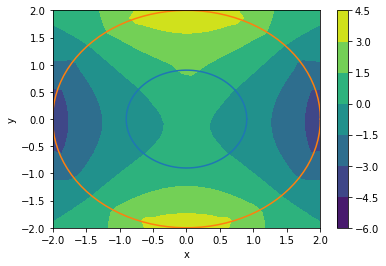

In [23]:
n_ = 30

x = np.linspace(-r2, r2, n_)
y = np.linspace(-r2, r2, n_)

xx_, yy_ = np.meshgrid(x, y)
zz_ = np.zeros([n_, n_])

for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        zz_[i][j] = u_approx([x[i], y[j]])

# Draw contour
fig_contour,ax=plt.subplots(1,1)
cp = ax.contourf(xx_, yy_, zz_)
fig_contour.colorbar(cp) # Add a colorbar to a plot

# Draw curves
xxx = np.linspace(0, 2*np.pi, 100)
yyy = np.linspace(0, 2*np.pi, 100)

ax.plot(x1(xxx)[0], x1(xxx)[1])
ax.plot(x2(xxx)[0], x2(xxx)[1])

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

<IPython.core.display.Javascript object>


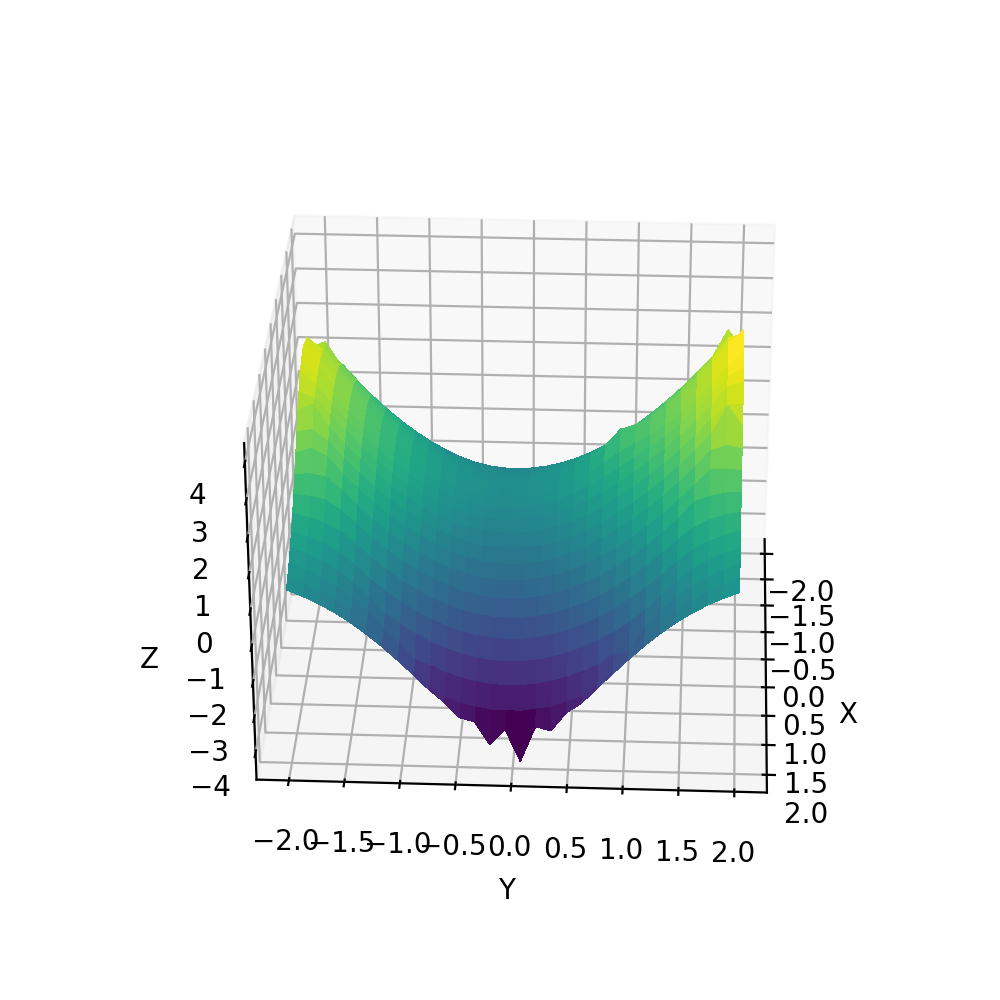

In [24]:
%matplotlib notebook

fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx_, yy_, zz_, rstride=1, cstride=1, linewidth=1, antialiased=False, cmap=cm.viridis)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [25]:
# zz__ = np.zeros([n_, n_])

# for i, x_ in enumerate(x):
#     for j, y_ in enumerate(y):
#         zz__[i][j] = u(x[i], y[j])

# fig = plt.figure(figsize=(5, 5))
# ax = fig.gca(projection='3d')

# surf = ax.plot_surface(xx_, yy_, zz__, rstride=1, cstride=1, linewidth=1, antialiased=False, cmap=cm.viridis)

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")

# plt.show()